# 1. EDA, ajuste de hiperparámetros y selección de modelos

In [78]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

## 1.1. EDA

**Key Concepts of Exploratory Data Analysis**
- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration

Reading the dataframes from the bz2 files.

In [79]:
""" Reading the dataframes """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2", compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2", compression="bz2", index_col=0)

In [80]:

disp_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


In [81]:
disp_df.shape

(4380, 76)

In [82]:
disp_df.head()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.0,0.0,0.000000,0.0,268.583582,244.241641,251.174486,269.741308,268.377441,...,252.504475,254.760271,263.342404,260.067843,0.0,10.000000,50.000000,106.636364,72.000000,11930700
V2,0.0,0.0,0.0,0.008182,0.2,251.725869,255.824126,272.163913,318.259924,307.929083,...,233.458263,233.027276,212.652054,222.052916,0.0,8.181818,35.909091,58.181818,42.090909,9778500
V3,0.0,0.0,0.0,0.000000,0.0,219.734547,211.996022,216.405820,235.529123,239.840132,...,232.828737,235.480750,245.177331,238.893102,0.0,10.272727,55.272727,118.454545,79.181818,9771900
V4,0.0,0.0,0.0,0.000000,0.0,253.499410,230.896544,235.857221,240.274556,237.804048,...,241.916776,243.398572,251.473036,247.503769,0.0,8.909091,46.000000,107.090909,73.636364,6466800
V5,0.0,0.0,0.0,0.000000,0.0,234.890020,238.927051,246.850822,271.577246,275.572826,...,233.706659,239.952805,258.128188,253.200684,0.0,8.909091,48.909091,106.272727,71.818182,11545200


In [83]:
result = disp_df.eq(0.0).sum()/len(disp_df)*100

# select only results over 50.0
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result


dswrf_s1_1    92.054795
uswrf_s1_1    90.844749
apcp_sf4_1    63.378995
apcp_sf5_1    61.278539
apcp_sf1_1    61.164384
apcp_sf2_1    60.296804
apcp_sf3_1    57.305936
tcdc_ea3_1    37.945205
tcdc_ea1_1    37.237443
tcdc_ea2_1    37.123288
tcdc_ea5_1    36.004566
tcdc_ea4_1    35.547945
dtype: float64

In [84]:
disp_df.isna().sum()

apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s2_1    0
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
Length: 76, dtype: int64

In [85]:
disp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

<AxesSubplot:>

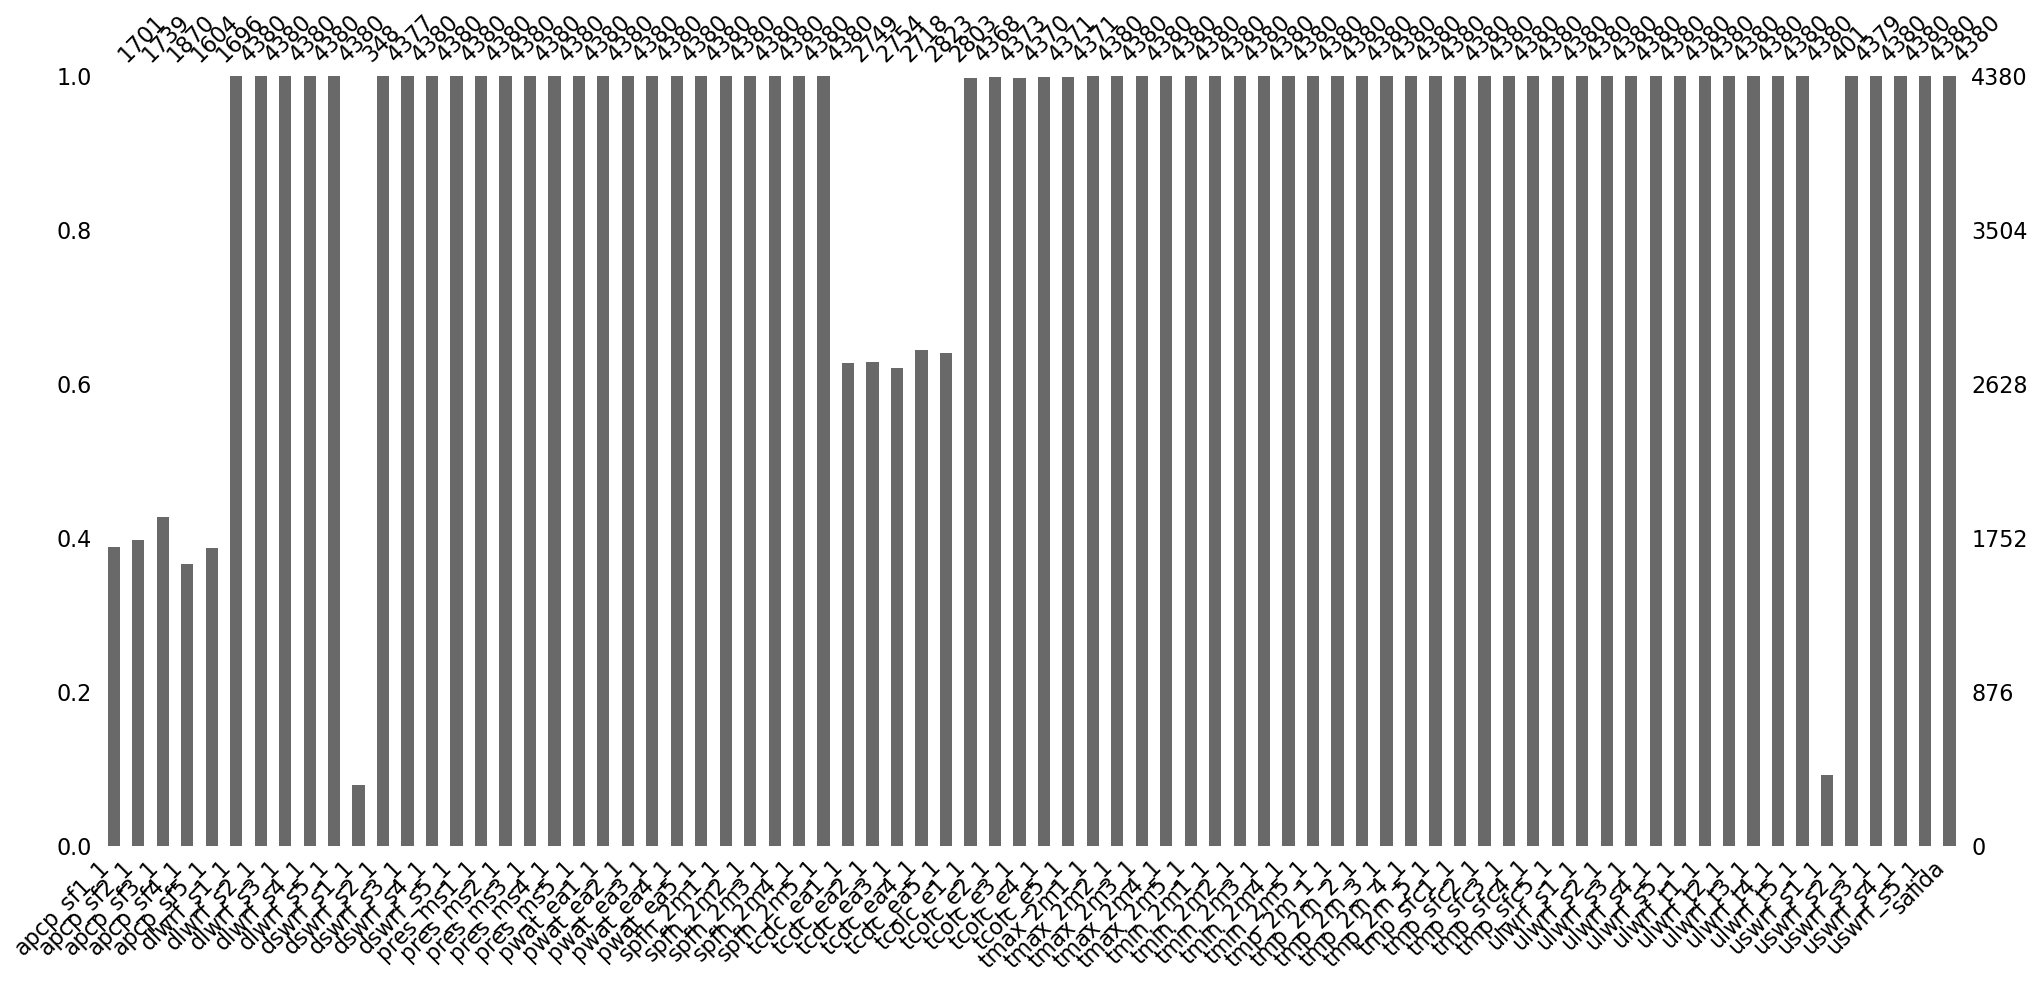

In [90]:
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
disp_df = disp_df.replace(0.0, np.nan)
msno.bar(disp_df, labels=True)

<AxesSubplot:>

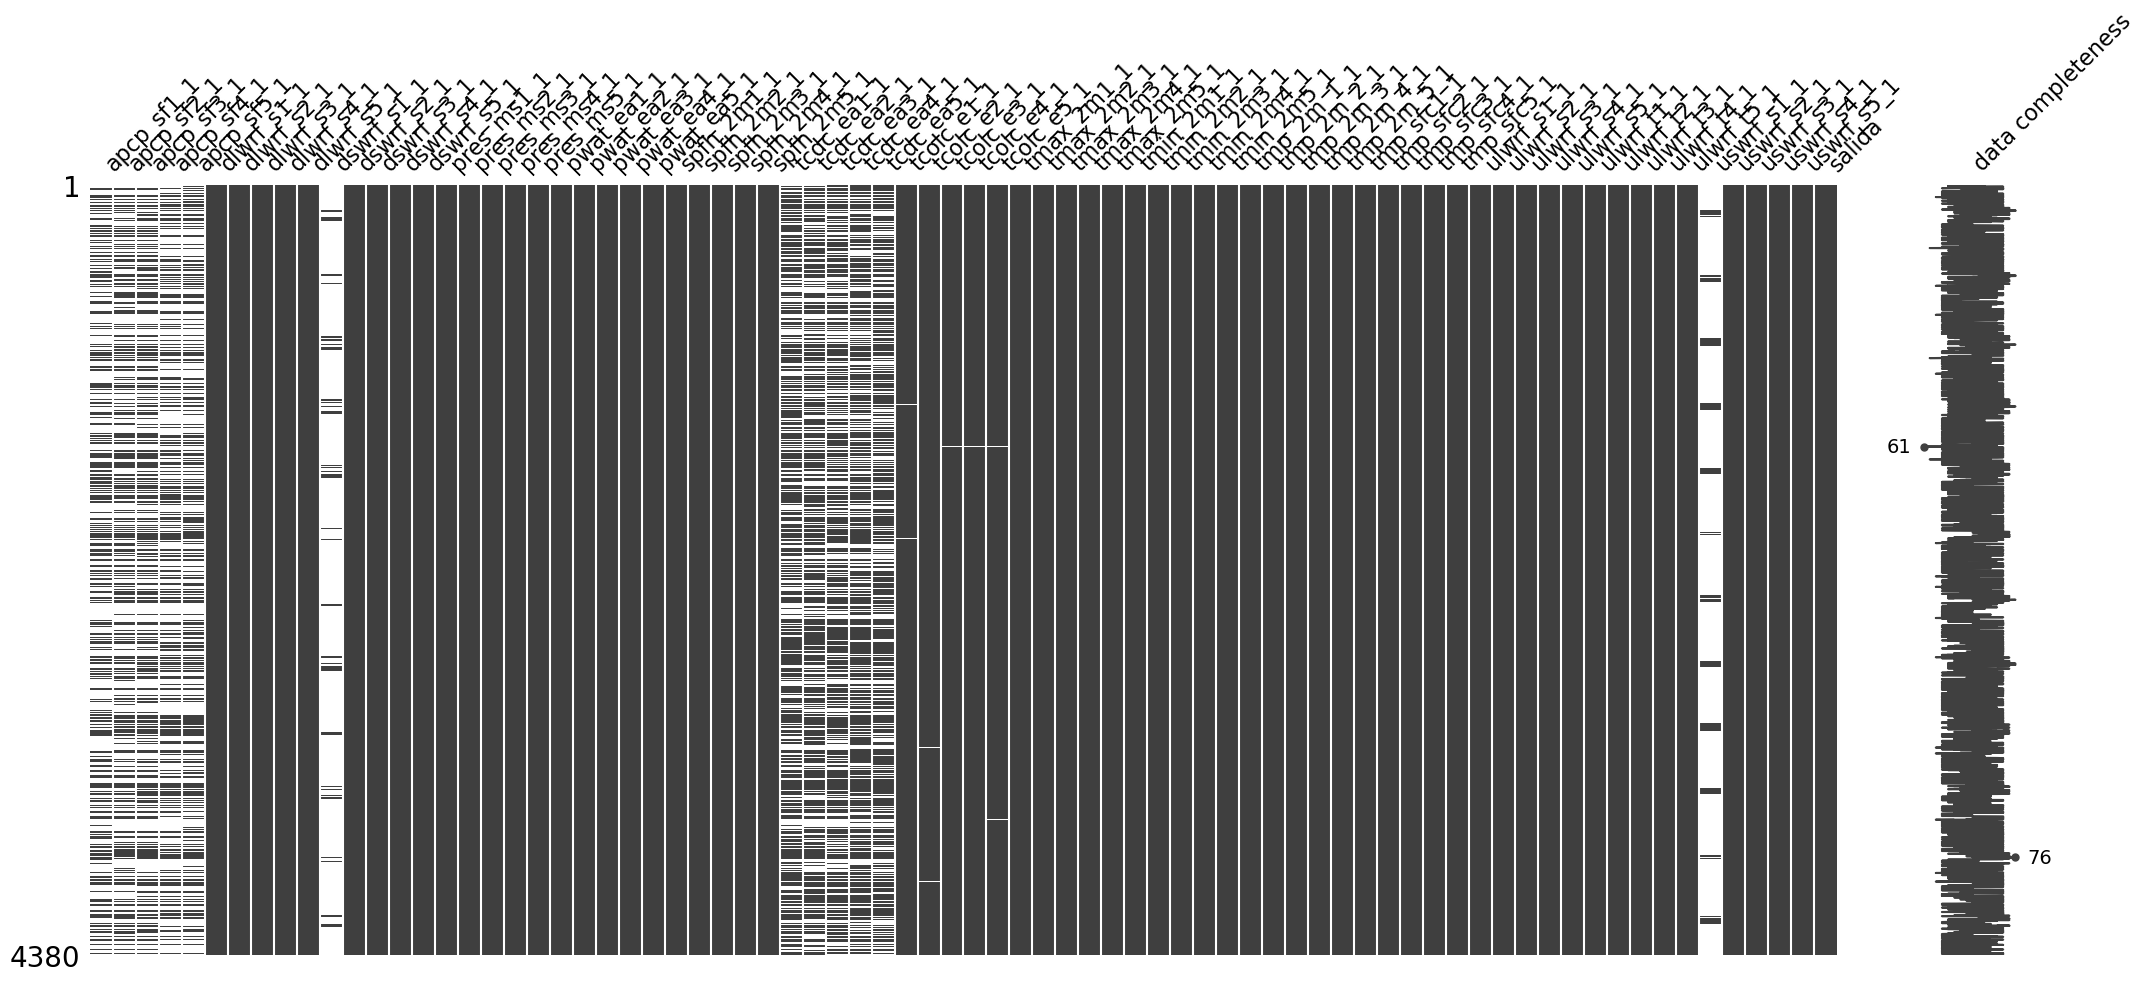

In [100]:
msno.matrix(disp_df, labels=True)

<AxesSubplot:>

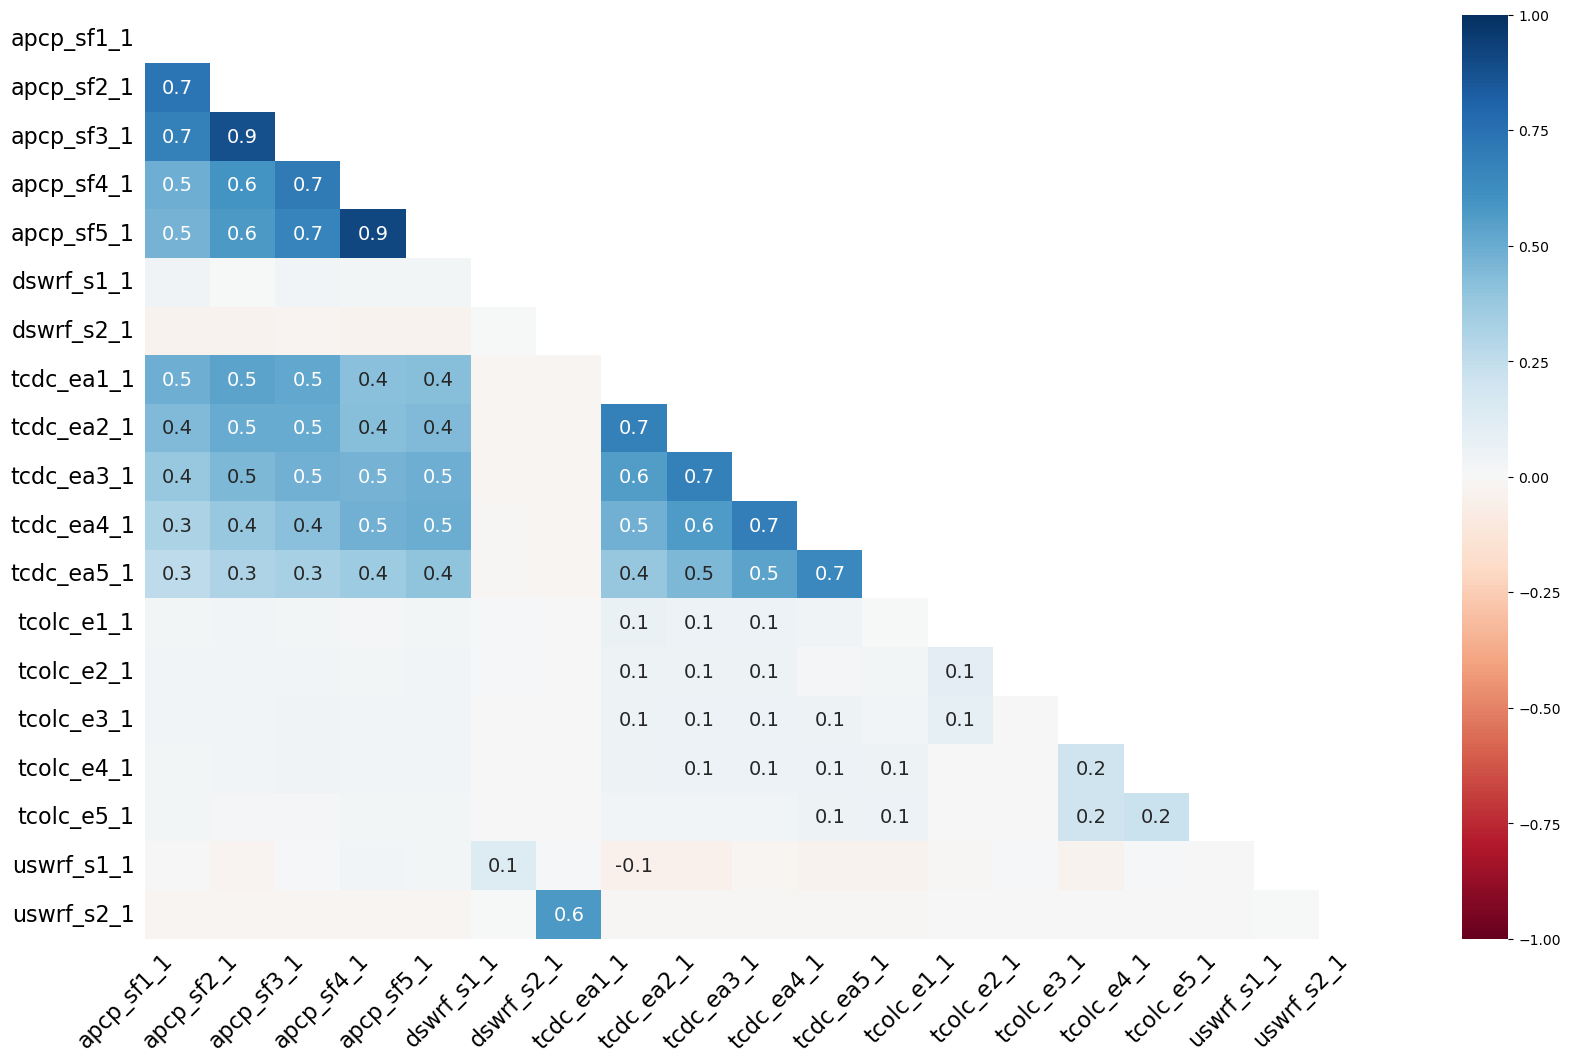

In [ ]:
msno.heatmap(disp_df)

<AxesSubplot:>

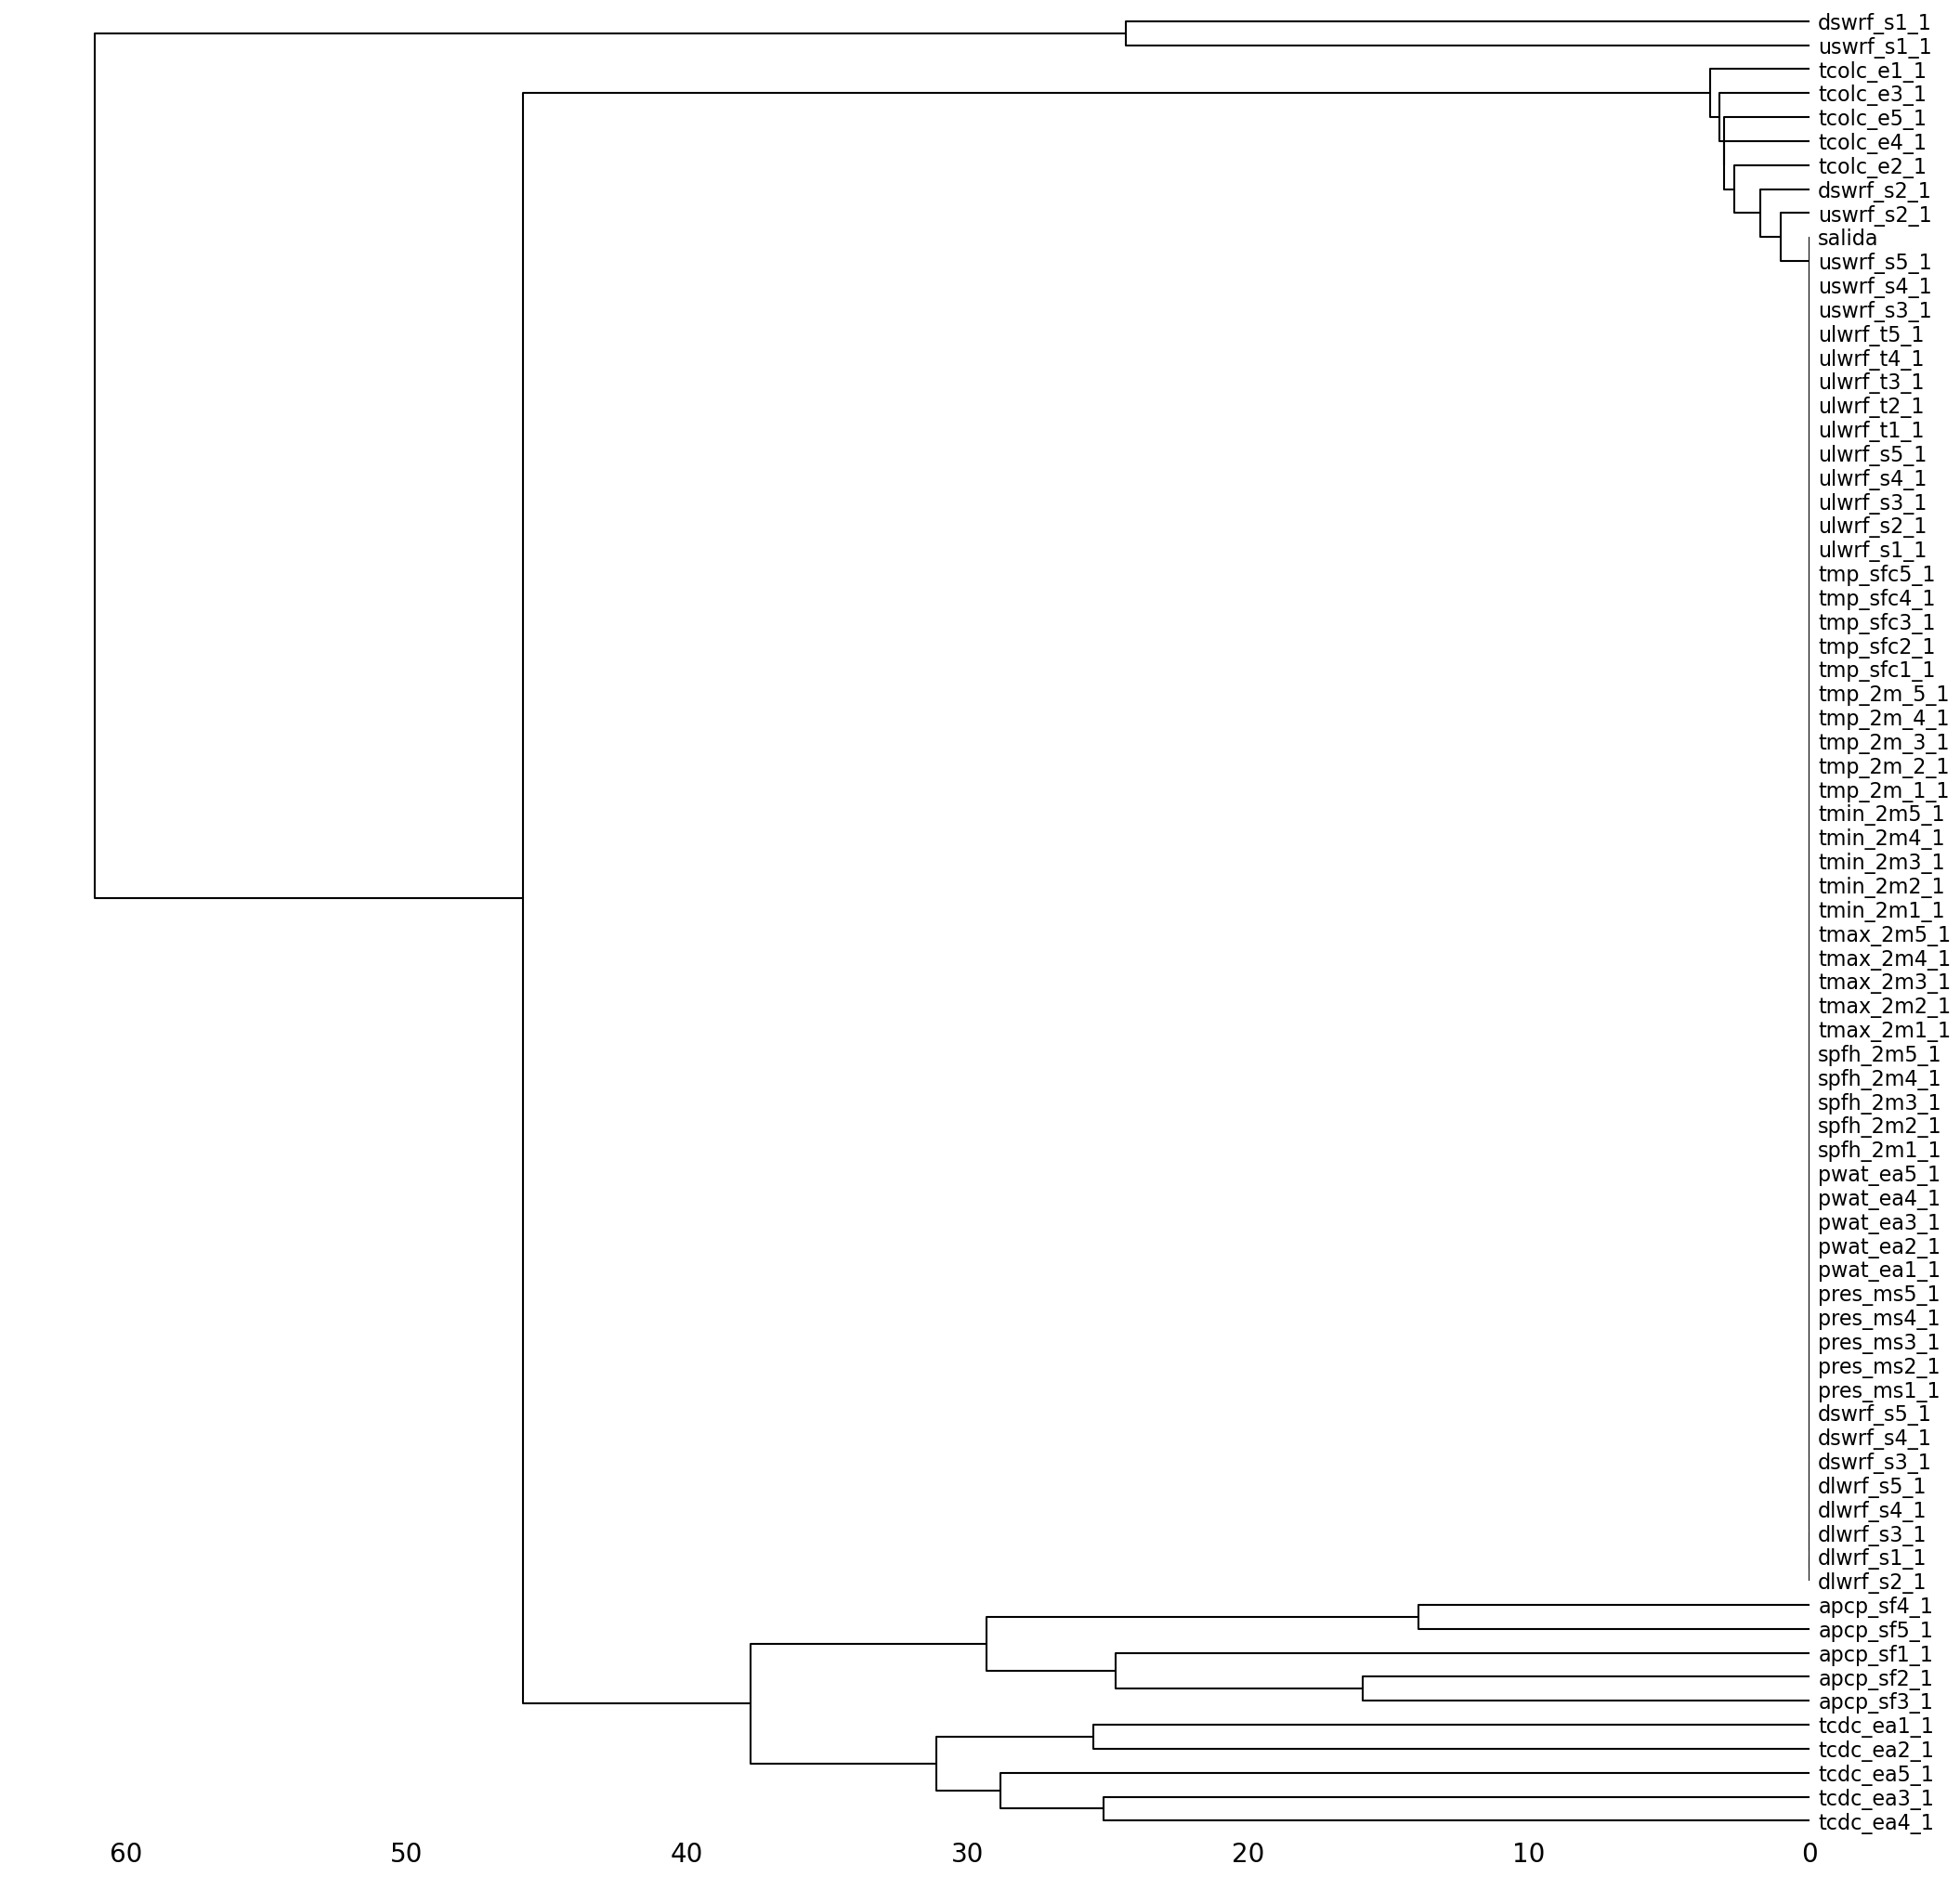

In [ ]:
msno.dendrogram(disp_df)